<a href="https://colab.research.google.com/github/udlbook/iclimbtrees/blob/main/notebooks/SAT_Binary_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary classification

The purpose of this Python notebook is to use investigate using SAT to learn a classifier that takes an input data point and establishes whether it belongs to one of two clases.  We'll learn the classifier using a training dataset consisting of data points with known labels.

You should have completed the notebook on SAT constructions before attempting this notebook.  

Work through the cells below, running each cell in turn. In various places you will see the words "TODO". Follow the instructions at these places and write code to complete the functions.

You can save a local copy of this notebook in your Google account and work through it in Colab (recommended) or you can download the notebook and run it locally using Jupyter notebook or similar. If you are using CoLab, we recommend that turn off AI autocomplete (under cog icon in top-right corner), which will give you the answers and defeat the purpose of the exercise.

A fully working version of this notebook with the complete answers can be found [here](https://colab.research.google.com/github/udlbook/udlbook/blob/main/Trees/LinearRegression_FitModel_Answers.ipynb).

Contact me at iclimbtreesmail@gmail.com if you find any mistakes or have any suggestions.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import scale
!pip install z3-solver
from z3 import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 61.9 MB/s eta 0:00:00


Let's start by creating some random data. We'll create 60 points and assign each to one of two random classes.  We'll keep the data in the $2\times 60$ matrix $X$ and the class labels in the length 60 vector $y$.

In [9]:
n_data = 60;
X, y = make_blobs(n_samples=n_data, centers=4, random_state=0, cluster_std=1.0)
# Put the data points in the columns
X = X.T
# Combine clusters
y = y % 2
# Scale to reasonable values
X = scale(X, axis=1) * 1.3
print("Data matrix size: (%d x %d)"%(X.shape[0],X.shape[1]))
print("Label vector size: %d"%(y.shape[0]))

Data matrix size: (2 x 60)
Label vector size: 60


Let's plot this data

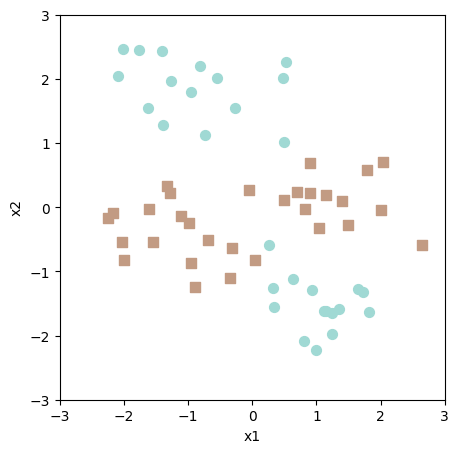

In [10]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
for i in range(n_data):
    if y[i] == 0:
        ax.scatter(X[0, i], X[1, i], marker='s', s=50, c='#c29b83') # Square for class 0
    else:
        ax.scatter(X[0, i], X[1, i], marker='o', s=50, c='#a0d9d4') # Circle for class 1
ax.set_xlabel('x1');
ax.set_ylabel('x2');
ax.set_ylim([-3,3])
ax.set_xlim([-3,3])
ax.set_aspect('equal')
plt.show()

Our goal wil be to learn a rule that (as much as possible) that takes and input data points and assigns the label 0 to the data if it is in the first class and the label 1 if it is in the second class.

We're going to formulate this as a SAT problem, so we need to deal with the fact that each 2D data point is based on continuous values.  To this end, we convert each data point $\mathbf{x}\in\mathbb{R}^2$ into a binary feature $\mathbf{x}\in \mathbb{R}^{N}$.

We'll do this by generating $N$ random lines in the 2D space and assigning a binary feature for a point depending on which side of the line it is on.

In [11]:
# Set seed so we get same result each time
np.random.seed(2)

# Number of random lines
n_features = 50

# Storage for the line params
line_params = np.zeros((3, n_features))
# Storage for the features themselves
features = np.zeros((n_features, n_data))

# Generate random lines and assign binary features
for c_feature in range(n_features):
    # Generate two random points to define a line
    point1 = np.random.uniform(low=-3, high=3, size=2)
    point2 = np.random.uniform(low=-3, high=3, size=2)

    # Calculate the line equation (ax + by + c = 0)
    a = point2[1] - point1[1]
    b = point1[0] - point2[0]
    c = -a * point1[0] - b * point1[1]

    # Store the line
    line_params[:, c_feature] = [a, b, c]

    # Assign binary features based on which side of the line each point is
    for c_data in range(n_data):
        if a * X[0, c_data] + b * X[1, c_data] + c > 0:
            features[c_feature, c_data] = 1

print("Feature matrix size: (%d x %d)"%(features.shape[0],features.shape[1]))

Feature matrix size: (50 x 60)


We'll now learn a single layer neural network to classify the data as well as possible.

We'll use this routine to draw the final result

In [12]:
def draw_decision_boundary(X,y,predict,predict_params):

  # Define a grid of values to plot
  x1_plot_vals = np.linspace(-3,3,400)
  x2_plot_vals = np.linspace(-3,3,400)
  x1_plot, x2_plot = np.meshgrid(x1_plot_vals, x2_plot_vals)

  # Make a prediction for each of these values
  y_plot = predict(x1_plot, x2_plot, predict_params)

  # Draw the points and the decision boundary
  fig,ax = plt.subplots(1,1,figsize=(5,5))
  plt.contourf(x1_plot_vals, x2_plot_vals, y_plot, cmap=plt.cm.RdBu, alpha=0.8)
  for i in range(n_data):
    if y[i] == 0:
        ax.scatter(X[0, i], X[1, i], marker='o', s=50, c='#c29b83') # Circle for class 0
    else:
        ax.scatter(X[0, i], X[1, i], marker='s', s=50, c='#a0d9d4') # Square for class 1
  ax.set_xlabel('x1');   ax.set_ylabel('x2');
  ax.set_ylim([-3,3]);  ax.set_xlim([-3,3])
  ax.set_aspect('equal')
  plt.show()

In [13]:
# SAT constructions that we will need

# Takes a list of z3.Bool variables and returns constraints
# ensuring that there is exactly one true
def exactly_one(x):
  return PbEq([(i,1) for i in x],1)

# Takes a list of z3.Bool variables and returns constraints
# ensuring that are at least k true
def at_least_k(x,k):
  return PbGe([(i,1) for i in x],k)

This is the main routine that runs the SAT solver.  It takes the binary features, true labels $y$ and the minimum number of correct answers required $k$.  

It sets up the binary variables used in the SAT formulation and it returns their values if the solver returns SAT.

In [14]:
def fit_multiple_feature_model(features, y, k):

  # Find number of features and data
  n_features = features.shape[0]
  n_data = features.shape[1]

  # These variables will identify which features are used
  features_used = [ z3.Bool("feat_used_{%d}"%(c_feature)) for c_feature in range(0,n_features)]
  # These variable will identify where each feature should be flipped
  features_flipped = [ z3.Bool("feat_flipped_{%d}"%(c_feature)) for c_feature in range(0,n_features)]
  # These variables will indicate the classification of the points based on each feature
  preactivations = [[ z3.Bool("preact_{%d,%d}"%(c_feature, c_data)) for c_data in range(0,n_data)]for c_feature in range(0,n_features)]
  # These variables will indicate the final classification of the points.
  y_est = [ z3.Bool("y_est_{%d}"%(c_data)) for c_data in range(0,n_data)]
  # These variables will indicate if the point is classified correctly
  y_correct = [ z3.Bool("y_correct_{%d}"%(c_data)) for c_data in range(0,n_data)]

  # Set up the SAT solver
  s = Solver()

  # Add the constraints
  s = add_multiple_feature_constraints(s, features_used, features_flipped, y_correct, y_est, preactivations, k, features)

  # Run the SAT solver
  sat_result = s.check()

  # If it is then draw crossword, otherwise return
  if sat_result == z3.sat:
      result = s.model()
      # Retrieve the final variables
      features_used_out = np.array([int(bool(result[z3.Bool("feat_used_{%d}"%(c_feature))])) for c_feature in range(0,n_features)])
      features_flipped_out = np.array([int(bool(result[z3.Bool("feat_flipped_{%d}"%(c_feature))])) for c_feature in range(0,n_features)])
      preactivations_out = np.array([[int(bool(result[z3.Bool("preact_{%d,%d}"%(c_feature,c_data))]))  for c_data in range(0,n_data)]for c_feature in range(0,n_features)] )
      y_est_out = np.array([int(bool(result[z3.Bool("y_est_{%d}"%(c_data))])) for c_data in range(0,n_data)])
      y_correct_out = np.array([int(bool(result[z3.Bool("y_correct_{%d}"%(c_data))])) for c_data in range(0,n_data)])
      return sat_result, features_used_out, features_flipped_out, y_est_out, preactivations_out, y_correct_out
  else:
      return sat_result, None, None, None, None, None

In [15]:
def add_multiple_feature_constraints(s, features_used, features_flipped, y_correct, y_est, preactivations, k, features):

  # Find number of features and data
  n_features = features.shape[0]
  n_data = features.shape[1]

  # Constraint 1:  For each preactivation (fancy word for term to be ANDed together)
  #                       either (i) the feature is not used (i.e., \overline{\phi}_k) and we return true whatever the input was or
  #                       or     (ii) the feature is used (i.e., \phi_k)  and we return a value that depends on the input and whether the feature was flipped.
  #                                      If the feature was not flipped (i.e., \overline{\theta}_k) we return the input z_j
  #                                      If it was flipped, we return its complement \overline{z}_j.
  for c_data in range(n_data):
    for c_feature in range(n_features):
        # TODO -- replace this expression (with equation 3.4.2 in the text)
        s.add(preactivations[c_feature][c_data])

  # Constraint 2:  y_est is logical AND of all estimates from individual features
  for c_data in range(n_data):
    # TODO -- replace this expression so that all the preativations for each data point are ANDed together
    s.add(y_est[c_data])

  # Constraint 3:  For each data point the data is correct if y_est matches the test label
  for c_data in range(0,n_data):
    s.add(y_correct[c_data] == (y_est[c_data] == bool(y[c_data])))

  # Constraint 4:  We require at least k features to be correct
  s.add(at_least_k(y_correct, k))

  return s

In [16]:
# TODO -- run this routine multiple times, until you find the largest number k of features that can be classified correctly (for which the model is SAT)
sat_result, features_used_out, features_flipped_out, y_est_out, preactivations_out, y_correct_out = fit_multiple_feature_model(features, y, k=20)

if sat_result == z3.sat:
  print("SAT")
  print("\nFeatures used:\n", features_used_out)
  print("\nFeatures flipped:\n", features_flipped_out)
  print("\nPreactivations \n",preactivations_out)
  print("\nY estimated (1st row) vs y_true (second row)\n",np.concatenate((y_est_out.reshape(1,n_data),y.reshape(1,n_data)),axis=0))
  print("\nCorrectly classified:\n", y_correct_out)
else:
  print("UNSAT")

SAT

Features used:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]

Features flipped:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]

Preactivations 
 [[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]

Y estimated (1st row) vs y_true (second row)
 [[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 0 1 1 1 1 1 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1 0 1 0 1 1 1 0 0 1 0
  1 0 0 0 0 0 1 1 1 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1]]

Correctly classified:
 [0 1 1 0 1 1 1 1 1 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1 0 1 0 1 1 1 0 0 1 0 1
 0 0 0 0 0 1 1 1 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1]


In [17]:
def predict_multiple_features(x1,x2,params):
  features_used = params["features_used"]
  feature_flipped = params["features_flipped"]
  line_params = params["line_params"]
  result = np.full(x1.shape, True, dtype=bool)
  n_features = len(features_used)
  for c_feature in range(n_features):
    if features_used[c_feature]:
      if feature_flipped[c_feature]:
        result = np.logical_and(result,line_params[0,c_feature] * x1 + line_params[1,c_feature] * x2 + line_params[2,c_feature] < 0)
      else:
        result = np.logical_and(result,line_params[0,c_feature] * x1 + line_params[1,c_feature] * x2 + line_params[2,c_feature] > 0)
  return result

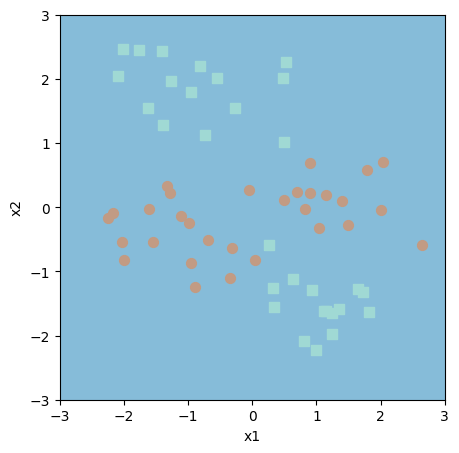

In [18]:
predict_params ={"line_params":line_params,"features_used":features_used_out,"features_flipped":features_flipped_out}
draw_decision_boundary(X,y,predict_multiple_features, predict_params)

If you did this correctly, it should be able to classify 45/60 points correctly points correctly and it will have chosen a blue region that separates the blue points at the top from the remaining points.   However, AND-ing together regions created by lines like this is guaranteed to produce a convex region for the blue points in class 1 (a convex region is one where any two points on the boundary can be joined with straight line without intersecting the boundary).

This limits the expressivity of the classifier.  A simple way to make progress is to compute several of these regions and logically OR them together to create a more complex region.  

In the terminology of neural networks, the computations for the individual regions are stored in the "activations" of "hidden variables".

In [21]:
def fit_multilayer_model(features, y, k, n_hidden):

  # Find number of features and data
  n_features = features.shape[0]
  n_data = features.shape[1]

  # These variables will identify which features are used
  features_used = [[ z3.Bool("feat_used_{%d,%d}"%(c_feature, c_hidden)) for c_hidden in range(0, n_hidden) ] for c_feature in range(0,n_features)]
  # These variable will identify where each feature should be flipped
  features_flipped = [[ z3.Bool("feat_flipped_{%d,%d}"%(c_feature, c_hidden)) for c_hidden in range(0, n_hidden) ] for c_feature in range(0,n_features)]
  # These variables will indicate the classification of the points based on each feature
  preactivations = [[[ z3.Bool("preact_{%d,%d,%d}"%(c_feature, c_data, c_hidden)) for c_hidden in range(0,n_hidden)] for c_data in range(0,n_data)]for c_feature in range(0,n_features)]
  # These variables will be the values at the hidden units (created by AND-ing together the relevant preactivations)
  activations = [[ z3.Bool("act_{%d,%d}"%(c_data, c_hidden)) for c_hidden in range(0,n_hidden)] for c_data in range(0,n_data)]

  # These variables will indicate the final classification of the points.
  y_est = [ z3.Bool("y_est_{%d}"%(c_data)) for c_data in range(0,n_data)]
  # These variables will indicate if the point is classified correctly
  y_correct = [ z3.Bool("y_correct_{%d}"%(c_data)) for c_data in range(0,n_data)]

  # Set up the SAT solver
  s = Solver()

  # Add the constraints
  s = add_multilayer_constraints(s, features_used, features_flipped, y_correct, y_est, preactivations, activations, k, n_hidden, features)

  # Run the SAT solver
  sat_result = s.check()

  # If it is then draw crossword, otherwise return
  if sat_result == z3.sat:
      result = s.model()
      # Retrieve the final variables
      features_used_out = np.array([[int(bool(result[z3.Bool("feat_used_{%d,%d}"%(c_feature, c_hidden))])) for c_hidden in range(0, n_hidden) ] for c_feature in range(0,n_features)])
      features_flipped_out = np.array([[int(bool(result[z3.Bool("feat_flipped_{%d,%d}"%(c_feature,c_hidden))])) for c_hidden in range(0, n_hidden) ]for c_feature in range(0,n_features)])
      preactivations_out = np.array([[[int(bool(result[z3.Bool("preact_{%d,%d}"%(c_feature,c_data))])) for c_hidden in range(0, n_hidden) ] for c_data in range(0,n_data)]for c_feature in range(0,n_features)] )
      activations_out = np.array([[ int(bool(result[z3.Bool("act_{%d,%d}"%(c_data, c_hidden))])) for c_hidden in range(0,n_hidden)] for c_data in range(0,n_data)])
      y_est_out = np.array([int(bool(result[z3.Bool("y_est_{%d}"%(c_data))])) for c_data in range(0,n_data)])
      y_correct_out = np.array([int(bool(result[z3.Bool("y_correct_{%d}"%(c_data))])) for c_data in range(0,n_data)])
      return sat_result, features_used_out, features_flipped_out, y_est_out, preactivations_out, activations_out, y_correct_out
  else:
      return sat_result, None, None, None, None, None, None

In [22]:
def add_multilayer_constraints(s, features_used, features_flipped, y_correct, y_est, preactivations, activations, k, n_hidden, features):

  # Find number of features and data
  n_features = features.shape[0]
  n_data = features.shape[1]

  # Constraint 1:  For each preactivation in each hidden variable (term to be ANDed together)
  #                       either (i) the feature is not used (i.e., \overline{\phi}_k) and we return true whatever the input was or
  #                       or     (ii) the feature is used (i.e., \phi_k)  and we return a value that depends on the input and whether the feature was flipped.
  #                                      If the feature was not flipped (i.e., \overline{\theta}_k) we return the input z_j
  #                                      If it was flipped, we return its complement \overline{z}_j.
  for c_data in range(n_data):
    for c_feature in range(n_features):
      for c_hidden in range (n_hidden):
        # TODO -- Replace this line
        s.add(preactivations[c_feature][c_data][c_hidden])

  # Constraint 2:  For each hidden layer activation is logical AND of all of the preactivations
  for c_data in range(n_data):
    for c_hidden in range(n_hidden):
      # TODO -- replace this line
      s.add(activations[c_data][c_hidden])

  # Constraint 3:  Estimated value is logical OR of all activations
  for c_data in range(n_data):
    # TODO replace this line
    s.add(y_est[c_data])

  # Constraint 5:  For each data point the data is correct if y_est matches the test label
  for c_data in range(0,n_data):
    s.add(y_correct[c_data] == (y_est[c_data] == bool(y[c_data])))

  # Constraint 6:  We require at least k features to be correct
  s.add(at_least_k(y_correct, k))

  return s

In [26]:
# TODO -- run this routine multiple times, until you find the largest number k of features that can be classified correctly (for which the model is SAT)
sat_result, features_used_out, features_flipped_out, y_est_out, preactivations_out, activations_out, y_correct_out = \
              fit_multilayer_model(features, y, k=20, n_hidden=3)


if sat_result == z3.sat:
  print("SAT")
  print("\nFeatures used hidden unit 1:\n", features_used_out[:,0])
  print("\nFeatures flipped hidden unit 1:\n", features_flipped_out[:,0])
  print("\nPreactivations hidden unit 1\n",preactivations_out[:,:,0])

  print("\nFeatures used hidden unit 2:\n", features_used_out[:,1])
  print("\nFeatures flipped hidden unit 2:\n", features_flipped_out[:,1])
  print("\nPreactivations hidden unit 2\n",preactivations_out[:,:,1])

  print("\nActivations\n",activations_out.T)

  print("\nY estimated (1st row) vs y_true (second row)\n",np.concatenate((y_est_out.reshape(1,n_data),y.reshape(1,n_data)),axis=0))
  print("\nCorrectly classified:\n", y_correct_out)
else:
  print("UNSAT")

SAT

Features used hidden unit 1:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]

Features flipped hidden unit 1:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]

Preactivations hidden unit 1
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Features used hidden unit 2:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]

Features flipped hidden unit 2:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]

Preactivations hidden unit 2
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Activations
 [[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1

In [27]:
def predict_multilayer(x1,x2,params):
  features_used = params["features_used"]
  feature_flipped = params["features_flipped"]
  line_params = params["line_params"]
  n_features = len(features_used)
  n_hidden = features_used.shape[1]

  prediction = np.full(x1.shape, False, dtype=bool)
  for c_hidden in range(n_hidden):
    activation = np.full(x1.shape, True, dtype=bool)
    for c_feature in range(n_features):
      if features_used[c_feature,c_hidden]:
        if feature_flipped[c_feature,c_hidden]:
          activation = np.logical_and(activation,line_params[0,c_feature] * x1 + line_params[1,c_feature] * x2 + line_params[2,c_feature] < 0)
        else:
          activation = np.logical_and(activation,line_params[0,c_feature] * x1 + line_params[1,c_feature] * x2 + line_params[2,c_feature] > 0)
    prediction = np.logical_or(prediction, activation)

  return prediction

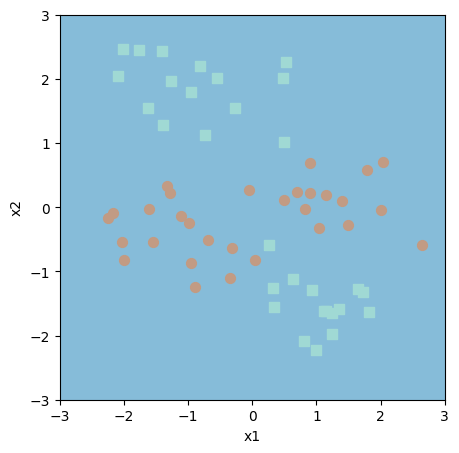

In [28]:
predict_params ={"line_params":line_params,"features_used":features_used_out,"features_flipped":features_flipped_out}
draw_decision_boundary(X,y,predict_multilayer, predict_params)

If you have done this correctly, you should find that you can now classify all 60 points correctly.